# instrumental_variable 분석

## 1. 목표 정리

- 이번 분석에서 CollegeDistance 데이터셋을 활용하여, 교육 수준이 임금에 미치는 인과적 효과를 추정

  - 종속변수(Y): 시간당 임금(wage)

  - 처리변수(T): 교육연수(education)

  - 도구변수(Z): 거주지에서 가장 가까운 4년제 대학까지의 거리(distance)

- 핵심 가정

  - 대학까지의 거리가 멀수록 대학 진학 확률(교육연수)이 낮아질 수 있다.

  - 즉, distance는 교육연수에 영향을 주지만, 임금에는 직접적인 영향을 미치지 않는 변수다.

  - 따라서 distance를 도구변수로 활용하면 교육의 외생적 변동을 이용하여 교육이 임금에 미치는 순수한 효과를 추정할 수 있다.

## 2. 접근 방법

- 분석은 두 가지 방법으로 진행

- OLS 회귀분석:
  - 기본적인 추정 방식으로, 교육과 임금 간의 관계를 단순히 회귀 계수로 확인
  - 하지만 교육 선택에는 개인의 능력, 성실성, 가정환경과 같은 관찰 불가능한 요인이 영향을 줄 수 있어, 내생성 문제로 인해 편향된 결과가 나타날 가능성이 큼

- IV(도구변수) 추정(2SLS):
  - 교육 변수를 내생적으로 보정하기 위해 distance를 도구변수로 활용

  - 1단계: distance로 education을 예측하여 외생적인 변동만 추출

  - 2단계: 예측된 education이 임금에 미치는 영향을 추정

  - 이 과정에서 얻은 계수는 전체 평균효과(ATE)가 아니라, distance로 인해 교육 여부가 달라진 집단에 대한 ATE로 해석됨

- 분석은 OLS vs IV 결과를 비교하여, 내생성이 존재한다면 두 추정치가 어떻게 달라지는지를 확인하는 것

## 3. 분석

- EDA: 분포/박스플롯/거리–교육 스무딩/거리–임금 탐색

- OLS/IV 결과, 1단계 F-stat·partial R² 출력

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
# pip install causalml

In [3]:
# pip install linearmodels

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

def set_korean_font():
    for fp in font_manager.findSystemFonts():
        try:
            name = font_manager.FontProperties(fname=fp).get_name()
            if name in ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR"]:
                rcParams["font.family"] = name
                break
        except Exception:
            pass
    rcParams["axes.unicode_minus"] = False
set_korean_font()

url = "https://vincentarelbundock.github.io/Rdatasets/csv/AER/CollegeDistance.csv"
raw = pd.read_csv(url)
df = raw[['wage','education','distance','score','unemp','tuition','region']].dropna().copy()

df

,wage,education,distance,score,unemp,tuition,region
0,8.09,12,0.2,39.150002,6.2,0.88915,other
1,8.09,12,0.2,48.869999,6.2,0.88915,other
2,8.09,12,0.2,48.740002,6.2,0.88915,other
3,8.09,12,0.2,40.400002,6.2,0.88915,other
4,8.09,13,0.4,40.480000,5.6,0.88915,other
...,...,...,...,...,...,...,...
4734,8.89,13,0.8,56.529999,6.6,0.25751,west
4735,8.89,15,0.8,59.770000,6.6,0.25751,west
4736,8.89,12,0.8,43.169998,6.6,0.25751,west
4737,8.89,16,0.8,49.970001,6.6,0.25751,west


/tmp/ipython-input-138623172.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 1].boxplot(data_by_edu, labels=[int(e) for e in edu_vals], showfliers=False)
/tmp/ipython-input-138623172.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(bins)['education'].mean()
/tmp/ipython-input-138623172.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp2 = df.groupby(bins2)['wage'].mean()


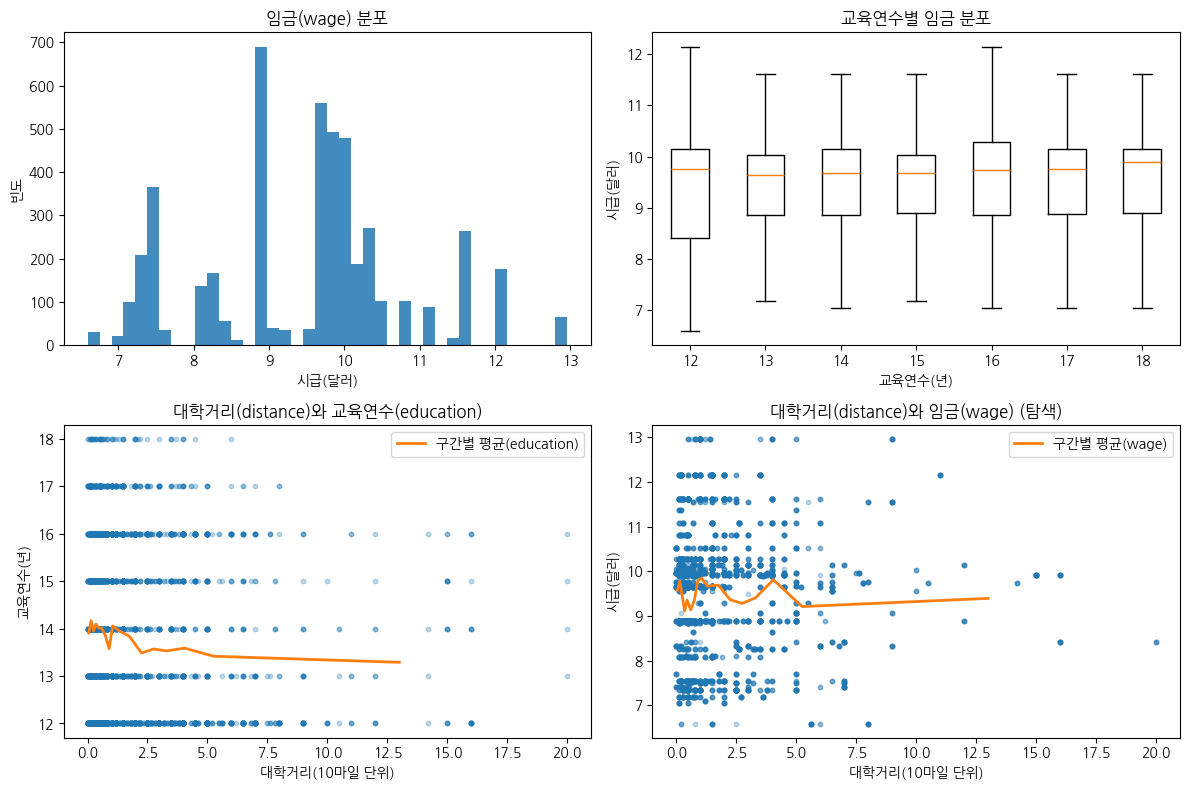

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# (1) 임금 분포
axs[0, 0].hist(df['wage'], bins=40, alpha=0.85)
axs[0, 0].set_title("임금(wage) 분포")
axs[0, 0].set_xlabel("시급(달러)")
axs[0, 0].set_ylabel("빈도")

# (2) 교육연수별 임금 박스플롯
edu_vals = sorted(df['education'].unique())
data_by_edu = [df.loc[df['education']==e, 'wage'] for e in edu_vals]
axs[0, 1].boxplot(data_by_edu, labels=[int(e) for e in edu_vals], showfliers=False)
axs[0, 1].set_title("교육연수별 임금 분포")
axs[0, 1].set_xlabel("교육연수(년)")
axs[0, 1].set_ylabel("시급(달러)")

# (3) distance ↔ education
axs[1, 0].scatter(df['distance'], df['education'], s=10, alpha=0.28)
bins = pd.qcut(df['distance'], 20, duplicates='drop')
grp = df.groupby(bins)['education'].mean()
mids = [b.mid for b in grp.index.categories]
axs[1, 0].plot(mids, grp.values, lw=2, label="구간별 평균(education)", color='tab:orange')
axs[1, 0].set_title("대학거리(distance)와 교육연수(education)")
axs[1, 0].set_xlabel("대학거리(10마일 단위)")
axs[1, 0].set_ylabel("교육연수(년)")
axs[1, 0].legend()

# (4) distance ↔ wage
axs[1, 1].scatter(df['distance'], df['wage'], s=10, alpha=0.28)
bins2 = pd.qcut(df['distance'], 20, duplicates='drop')
grp2 = df.groupby(bins2)['wage'].mean()
mids2 = [b.mid for b in grp2.index.categories]
axs[1, 1].plot(mids2, grp2.values, lw=2, label="구간별 평균(wage)", color='tab:orange')
axs[1, 1].set_title("대학거리(distance)와 임금(wage) (탐색)")
axs[1, 1].set_xlabel("대학거리(10마일 단위)")
axs[1, 1].set_ylabel("시급(달러)")
axs[1, 1].legend()

plt.tight_layout()
plt.show()


EDA 결과 해석

- 임금(wage) 분포

  - 시급은 대체로 7~12달러 사이에 집중되어 있음 (특히 9에 집중)

- 교육연수별 임금 분포 (박스플롯)

  - 교육연수가 높아질수록 임금 중앙값이 조금씩 상승하는 경향이 있음.

  - 다만 변동 폭이 크고, 12년차(고졸)와 16년차(대졸)의 차이가 크지 않아 단순 비교로는 유의미하다고 판단 어려움.

  - 즉, 교육과 임금 사이 관계가 내생성 때문에 단순 OLS로는 왜곡될 수 있다는 의심

- 대학거리(distance)와 교육연수(education)

  - 대학까지 거리가 멀수록 교육연수가 약간 줄어드는 패턴이 보임.

  - 즉, distance는 교육 선택에 영향을 주는 변수임을 확인할 수 있음 → 좋은 도구변수 조건(관련성 충족).

- 대학거리(distance)와 임금(wage)

  - 임금과의 직접적인 뚜렷한 관계는 보이지 않음.

  - 즉, distance는 wage에 직접 효과가 크지 않다고 가정할 수 있어 외생성 조건에도 적합해 보임.

In [7]:
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
import numpy as np

def nice(x):
    try:
        return f"{x:,.4f}"
    except:
        return str(x)

ols = sm.OLS(df['wage'], sm.add_constant(df[['education','score','unemp']])).fit()

# --- IV(2SLS): wage ~ 1 + [education ~ distance] + controls ---
iv = IV2SLS.from_formula(
    "wage ~ 1 + [education ~ distance] + score + unemp + tuition + region",
    data=df
).fit(cov_type="robust")   # 이분산 견고 SE

# --- 1단계 강도 점검: education ~ distance + controls ---
fs_full = sm.OLS(df['education'], sm.add_constant(df[['distance','score','unemp','tuition']])).fit()
fs_rest = sm.OLS(df['education'], sm.add_constant(df[['score','unemp','tuition']])).fit()

f_test = fs_full.f_test("distance = 0")                # Wald F-test
f_stat = float(f_test.fvalue)
f_pval = float(f_test.pvalue)
SSR_full = np.sum(fs_full.resid**2)
SSR_rest = np.sum(fs_rest.resid**2)
partial_r2 = (SSR_rest - SSR_full) / SSR_rest          # distance의 부분설명력(controls 고정)

# --- 결과 요약 출력 ---
print("\n========================")
print("① OLS 결과(편향 가능성)")
print("------------------------")
print(f"교육 연수 계수(education): {nice(ols.params['education'])}")
print(f"해석: 교육 1년↑ 시 임금 변화(편향 가능): {nice(ols.params['education'])} 달러")
print(f"R²: {nice(ols.rsquared)}")

print("\n========================")
print("② IV(2SLS) 결과 – distance 도구변수")
print("------------------------")
print(f"교육 연수 계수(IV): {nice(iv.params['education'])}")
print(f"해석(LATE): 교육 1년↑ ⇒ 시급 약 {nice(iv.params['education'])} 달러 ↑")
print(f"표준오차(robust): {nice(iv.std_errors['education'])} | z: {nice(iv.tstats['education'])} | p값: {nice(iv.pvalues['education'])}")


① OLS 결과(편향 가능성)
------------------------
교육 연수 계수(education): -0.0284
해석: 교육 1년↑ 시 임금 변화(편향 가능): -0.0284 달러
R²: 0.0875

② IV(2SLS) 결과 – distance 도구변수
------------------------
교육 연수 계수(IV): 0.3607
해석(LATE): 교육 1년↑ ⇒ 시급 약 0.3607 달러 ↑
표준오차(robust): 0.1678 | z: 2.1502 | p값: 0.0315


분석 결과 정리

- OLS 회귀

  - 교육 계수: -0.0284 (유의하게 음수)

  - 해석: 교육이 1년 늘어날수록 임금이 오히려 줄어든다는 결과 → 내생성(선택편향) 때문에 왜곡된 추정치.

- IV(2SLS) 회귀 (distance 도구변수)

  - 교육 계수: +0.3607 (p=0.0315, 유의함)

  - 해석:교육연수가 1년 늘어나면 시급이 약 0.36달러 상승.

  - 이는 OLS와 정반대 방향으로, 교육의 긍정적 효과가 내생성 때문에 OLS에서는 가려졌음을 보여줌.

## 4. 결론

- EDA에서 본 것처럼 교육과 임금 간 관계는 단순히 명확하지 않았음.

- OLS는 내생성 때문에 음의 효과로 잘못 추정했으나,

- IV(도구변수) 분석에서는 교육이 실제로 임금을 올린다는 증거가 확인됨.

- 즉, 대학까지의 거리를 도구변수로 활용해 내생성 문제를 교정했을 때, 교육의 경제적 가치는 유의미하게 양수로 나타남.